In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
pwd = os.getcwd()
print(pwd)

f:\research\NbN_MS_project\comments_on_draft1\computations


In [3]:
raw_df = pd.read_excel(pwd + '/data/NbN.xlsx')
print(f'Shape of the imported dataset is: ', raw_df.shape)
raw_df.head()

Shape of the imported dataset is:  (94, 6)


,method,substrate,temperature,pressure,thickness,Tc_K
0,DcMs,Al2O3,600.0,6.756078,4.3,11.00
1,DcMs,Al2O3,600.0,6.756078,4.4,11.30
2,DcMs,Al2O3,600.0,6.756078,4.4,11.10
3,DcMs,Al2O3,600.0,6.756078,10.0,14.30
4,DcMs,Al2O3,750.0,0.500000,3.2,9.87


In [4]:
def percentageOfnull(df):
    nan_count = df.isna().sum().sort_values(ascending=False)
    nan_percentage = ((df.isna().sum()/df.isna().count())*100).sort_values(ascending=False)
    train_test_dtype = df.dtypes
    df_info = pd.concat([nan_count,nan_percentage,train_test_dtype],axis=1,keys=['Null Count','Null Percentage','DataTypes'])
    return df_info[df_info['Null Count']>0]


percentageOfnull(raw_df)

,Null Count,Null Percentage,DataTypes


In [5]:
df = raw_df.copy()

In [6]:
numerical_feats = list(df.drop('Tc_K',axis=1).select_dtypes(include='number'))
categorical_feats = list(df.select_dtypes(exclude='number'))
num_feats = [item for item in numerical_feats]

method_list = [df['method'].unique()]
substrate_list = [df['substrate'].unique()]

for col in df.select_dtypes(exclude=['number']):
  print(f'{col:-<30}, {df[col].unique()}')

method------------------------, ['DcMs' 'IBAD' 'RfMs' 'PLD']
substrate---------------------, ['Al2O3' 'GaAs' 'LiNbO3' 'MgF2' 'MgO' 'Si' 'SiN' 'HfO2']


In [7]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
#from sklearn.preprocessing import StandardScaler

LABELS = df.drop('Tc_K', axis=1).columns
encoder = LabelEncoder()
for col in LABELS:
    # Check if object
    if df[col].dtype == 'O':
        df[col] = encoder.fit_transform(df[col])
        
    elif df[col].dtype == 'bool':
        df[col] = df[col].astype('int')

scaler = MinMaxScaler()

# Apply Standard Scaling
#df[num_feats] = scaler.fit_transform(df[num_feats])
df.head()

,method,substrate,temperature,pressure,thickness,Tc_K
0,0,0,600.0,6.756078,4.3,11.00
1,0,0,600.0,6.756078,4.4,11.30
2,0,0,600.0,6.756078,4.4,11.10
3,0,0,600.0,6.756078,10.0,14.30
4,0,0,750.0,0.500000,3.2,9.87


In [8]:
encoded_method = [df['method'].unique()]
encoded_substrate = [df['substrate'].unique()]
#print(encoded_method)
#print(encoded_substrate)


from itertools import chain
df_method = pd.DataFrame()
df_substrate = pd.DataFrame()

df_method['method'] = pd.Series(list(chain.from_iterable(method_list)))
df_substrate['substrate'] = pd.Series(list(chain.from_iterable(substrate_list)))
df_method['Encoded_method'] = pd.Series(list(chain.from_iterable(encoded_method)))
df_substrate['Encoded_substrate'] = pd.Series(list(chain.from_iterable(encoded_substrate)))


print(df_method)
print(df_substrate)

  method  Encoded_method
0   DcMs               0
1   IBAD               1
2   RfMs               3
3    PLD               2
  substrate  Encoded_substrate
0     Al2O3                  0
1      GaAs                  1
2    LiNbO3                  3
3      MgF2                  4
4       MgO                  5
5        Si                  6
6       SiN                  7
7      HfO2                  2


In [9]:
X = df.drop(["Tc_K"], axis=1)
y = df.Tc_K

X.head()

,method,substrate,temperature,pressure,thickness
0,0,0,600.0,6.756078,4.3
1,0,0,600.0,6.756078,4.4
2,0,0,600.0,6.756078,4.4
3,0,0,600.0,6.756078,10.0
4,0,0,750.0,0.500000,3.2


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Shapes of X_train, y_train, X_test, and y_test are {}, {}, {} and {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Shapes of X_train, y_train, X_test, and y_test are (75, 5), (75,), (19, 5) and (19,)


In [11]:
def prediction_error_plot(predicted_train, predicted_test, y1=y_train, y2=y_test):
    plt.style.use('ggplot')
    plt.figure()
    plt.scatter(y1, predicted_train, c='r', label='Train data')
    plt.scatter(y2, predicted_test, c='b', label='Test data')
    plt.plot(y_train, y_train, c='r')
    plt.xlabel('Actual T_c (K)')
    plt.ylabel('Predicted T_c (K)')
    plt.legend()
    return plt.show()

In [12]:
def model_builder(model_name):
    model_name.fit(X_train, y_train)
    y_pred_train = model_name.predict(X_train)
    y_pred_test = model_name.predict(X_test)

    
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_test)
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
    print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
    print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print("r2 on train set: {:.4f}".format(r2_train))
    print("r2 on test set: {:.4f}".format(r2_test))
    prediction_error_plot(y_pred_train, y_pred_test)

The mean squared error (MSE) on test set: 1.5536
The root mean squared error (RMSE) on test set: 1.2464
The mean absolute error (MAE) on test set: 0.9844
r2 on train set: 0.9901
r2 on test set: 0.7150


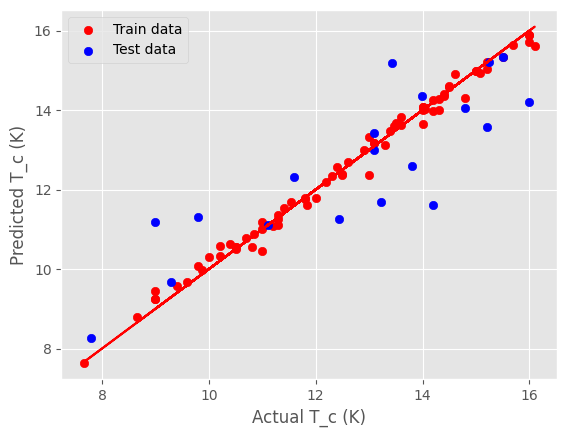

In [16]:
params = {
    "n_estimators": 200,
    "max_depth": 7,
    "min_samples_split": 13,
    "learning_rate": 0.05,
    "loss": "squared_error",
}

from sklearn import ensemble
gbr = ensemble.GradientBoostingRegressor(**params)
model_builder(gbr)

In [14]:
m = []
s = []
T = []
p = []
t = []


methods = [0]
substrates = [5]

temperatures = [i for i in range(0, 1501, 50)]
pressures =  np.arange(0.0, 6.3, 0.5)
thicknesses = np.arange(3, 2050, 50)


for method in methods:
    for substrate in substrates:
        for temperature in temperatures:
            for pressure in pressures:
                for thickness in thicknesses:
                    m.append(method)
                    s.append(substrate)
                    T.append(temperature)
                    p.append(pressure)
                    t.append(thickness)


df2 = pd.DataFrame(
{
    'method': m,
    'substrate': s,
    'temperature': T,
    'pressure': p,
    'thickness': t
}
)
print(df2.shape)
df2.head()

(16523, 5)


,method,substrate,temperature,pressure,thickness
0,0,5,0,0.0,3
1,0,5,0,0.0,53
2,0,5,0,0.0,103
3,0,5,0,0.0,153
4,0,5,0,0.0,203


In [15]:
pred_2 = gbr.predict(df2)
print(np.max(pred_2))
df2['predicted_Tc'] = pred_2
df2.head()

16.16598660942652


,method,substrate,temperature,pressure,thickness,predicted_Tc
0,0,5,0,0.0,3,10.225289
1,0,5,0,0.0,53,13.466215
2,0,5,0,0.0,103,14.740982
3,0,5,0,0.0,153,12.518250
4,0,5,0,0.0,203,14.397693


In [16]:
df2 = df2.sample(frac = 1).reset_index(drop=True)
#df2.to_excel(pwd + '/results/predicted_on_three_features_updated.xlsx', index=False)
sorted = df2.sort_values(by=['predicted_Tc'], ascending=False).reset_index(drop=True)
sorted.head()

,method,substrate,temperature,pressure,thickness,predicted_Tc
0,0,5,400,2.5,103,16.165987
1,0,5,400,2.0,103,16.165987
2,0,5,550,2.5,103,16.138865
3,0,5,600,2.5,103,16.138865
4,0,5,650,2.5,103,16.138865


In [17]:
m = []
s = []
T = []
p = []
t = []

methods = [0]
substrates = [5]

temperatures = [400] #[i for i in range(10, 1501, 50)]
pressures =  [2]  #np.arange(0.01, 10, 0.5)
thicknesses = np.arange(3, 2001, 1)

for method in methods:
    for substrate in substrates:
        for temperature in temperatures:
            for pressure in pressures:
                for thickness in thicknesses:
                    m.append(method)
                    s.append(substrate)
                    T.append(temperature)
                    p.append(pressure)
                    t.append(thickness)


df3 = pd.DataFrame(
{
    'method': m,
    'substrate': s,
    'temperature': T,
    'pressure': p,
    'thickness': t
}
)
print(df3.shape)

df3.head()

(1998, 5)


,method,substrate,temperature,pressure,thickness
0,0,5,400,2,3
1,0,5,400,2,4
2,0,5,400,2,5
3,0,5,400,2,6
4,0,5,400,2,7


In [18]:
pred_3 = gbr.predict(df3)
print(np.max(pred_3))

df3['predicted_Tc'] = pred_3
#df3.to_csv(pwd + '/t_Tc.csv', index=False)
a = df3.sort_values(by=['predicted_Tc'], ascending=False).reset_index(drop=True)
a.head()

16.337618717746594


,method,substrate,temperature,pressure,thickness,predicted_Tc
0,0,5,400,2,136,16.337619
1,0,5,400,2,126,16.337619
2,0,5,400,2,123,16.337619
3,0,5,400,2,124,16.337619
4,0,5,400,2,146,16.337619


In [19]:
m = []
s = []
T = []
p = []
t = []

methods = [0]
substrates = [5]

temperatures = [400] #[i for i in range(10, 1501, 50)]
pressures =  [2]  #np.arange(0.01, 10, 0.5)
thicknesses =  np.arange(5, 2000, 5)
#thicknesses = [5, 50, 250, 400, 600, 750, 900, 1050, 1200, 1350, 1500, 1650, 1800, 2000]

for method in methods:
    for substrate in substrates:
        for temperature in temperatures:
            for pressure in pressures:
                for thickness in thicknesses:
                    m.append(method)
                    s.append(substrate)
                    T.append(temperature)
                    p.append(pressure)
                    t.append(thickness)


df3 = pd.DataFrame(
{
    'method': m,
    'substrate': s,
    'temperature': T,
    'pressure': p,
    'thickness': t
}
)

pred_3 = gbr.predict(df3)
print(np.max(pred_3))

df3['predicted_Tc'] = pred_3
df3.to_excel(pwd + '/spline/Thickness_vs_Tc.xlsx', index=False)
a = df3.sort_values(by=['predicted_Tc'], ascending=False).reset_index(drop=True)
a.head()

16.337618717746594


,method,substrate,temperature,pressure,thickness,predicted_Tc
0,0,5,400,2,140,16.337619
1,0,5,400,2,135,16.337619
2,0,5,400,2,125,16.337619
3,0,5,400,2,130,16.337619
4,0,5,400,2,145,16.337619


In [20]:
m = []
s = []
T = []
p = []
t = []

methods = [0]
substrates = [5]

temperatures = [i for i in range(0, 1501, 5)]
pressures =  [2.0]  #np.arange(0.01, 10, 0.5)
thicknesses = [136]   #np.arange(50, 2001, 50)

for method in methods:
    for substrate in substrates:
        for temperature in temperatures:
            for pressure in pressures:
                for thickness in thicknesses:
                    m.append(method)
                    s.append(substrate)
                    T.append(temperature)
                    p.append(pressure)
                    t.append(thickness)


df4 = pd.DataFrame(
{
    'method': m,
    'substrate': s,
    'temperature': T,
    'pressure': p,
    'thickness': t
}
)
print(df4.shape)

pred_4 = gbr.predict(df4)
print(np.max(pred_4))

df4['predicted_Tc'] = pred_4
b = df4.sort_values(by=['predicted_Tc'], ascending=False).reset_index(drop=True)
b.to_excel(pwd + '/spline/Temperature_vs_Tc_6.xlsx', index=False)
b.head(10)

(301, 5)
16.47431718661049


,method,substrate,temperature,pressure,thickness,predicted_Tc
0,0,5,375,2.0,136,16.474317
1,0,5,380,2.0,136,16.474313
2,0,5,385,2.0,136,16.474313
3,0,5,390,2.0,136,16.474313
4,0,5,395,2.0,136,16.416211
5,0,5,410,2.0,136,16.337619
6,0,5,405,2.0,136,16.337619
7,0,5,400,2.0,136,16.337619
8,0,5,415,2.0,136,16.337619
9,0,5,420,2.0,136,16.337619


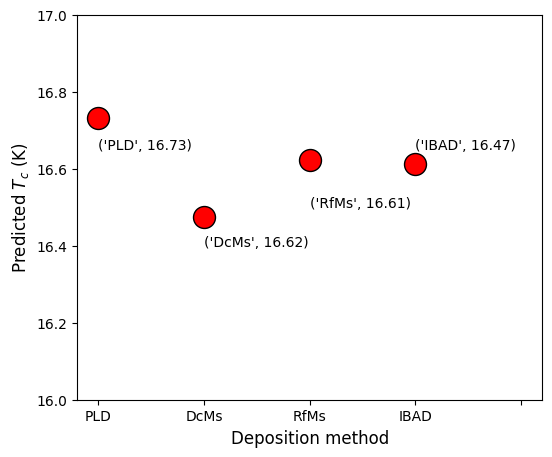

In [21]:
method_2 = ['PLD','DcMs', 'RfMs', 'IBAD',  '']
predicted_Tc = [16.7316, 16.4743, 16.6230, 16.6125,  0]



plt.style.use('default')
plt.figure(figsize=(6,5))
plt.scatter(x=method_2, y=predicted_Tc, c='r', edgecolors=(0, 0, 0), marker="o", s=250)

plt.xlabel('Deposition method', fontsize=12)
plt.ylabel('Predicted $T_{c}$ (K)', fontsize=12)

plt.text(method_2[0], 16.65, (method_2[0], 16.73))
plt.text(method_2[1], 16.40, (method_2[1], 16.62))
plt.text(method_2[2], 16.50, (method_2[2], 16.61))
plt.text(method_2[3], 16.65, (method_2[3], 16.47))

plt.ylim(16,17)
#plt.savefig(pwd + '/figures/cross_validated_predictions.png', dpi=350, bbox_inches="tight")
plt.show()

In [22]:
m = []
s = []
T = []
p = []
t = []

methods = [3]
substrates = [0, 1, 2, 3, 4, 5, 6, 7]

temperatures = [375]
pressures =  [2.0]  #np.arange(0.01, 10, 0.5)
thicknesses = [136]   #np.arange(50, 2001, 50)

for method in methods:
    for substrate in substrates:
        for temperature in temperatures:
            for pressure in pressures:
                for thickness in thicknesses:
                    m.append(method)
                    s.append(substrate)
                    T.append(temperature)
                    p.append(pressure)
                    t.append(thickness)


df5 = pd.DataFrame(
{
    'method': m,
    'substrate': s,
    'temperature': T,
    'pressure': p,
    'thickness': t
}
)
print(df5.shape)

pred_5 = gbr.predict(df5)
print(np.max(pred_5))

df5['predicted_Tc'] = pred_5
b = df5.sort_values(by=['predicted_Tc'], ascending=False).reset_index(drop=True)
b['decoded_substrate'] = b['substrate'].replace([0, 1, 3, 4, 5, 6, 7, 2], ['Al2O3', 'GaAs', 'LiNbO3', 'MgF2', 'MgO', 'Si', 'SiN', 'HfO2'])
b.head(10)

(8, 5)
16.731613965189624


,method,substrate,temperature,pressure,thickness,predicted_Tc,decoded_substrate
0,3,5,375,2.0,136,16.731614,MgO
1,3,4,375,2.0,136,16.583703,MgF2
2,3,3,375,2.0,136,16.473286,LiNbO3
3,3,6,375,2.0,136,16.142240,Si
4,3,0,375,2.0,136,16.049662,Al2O3
5,3,2,375,2.0,136,15.298379,HfO2
6,3,1,375,2.0,136,15.298379,GaAs
7,3,7,375,2.0,136,10.117871,SiN


In [23]:
df5

,method,substrate,temperature,pressure,thickness,predicted_Tc
0,3,0,375,2.0,136,16.049662
1,3,1,375,2.0,136,15.298379
2,3,2,375,2.0,136,15.298379
3,3,3,375,2.0,136,16.473286
4,3,4,375,2.0,136,16.583703
5,3,5,375,2.0,136,16.731614
6,3,6,375,2.0,136,16.142240
7,3,7,375,2.0,136,10.117871


In [24]:
print(df_substrate)

  substrate  Encoded_substrate
0     Al2O3                  0
1      GaAs                  1
2    LiNbO3                  3
3      MgF2                  4
4       MgO                  5
5        Si                  6
6       SiN                  7
7      HfO2                  2


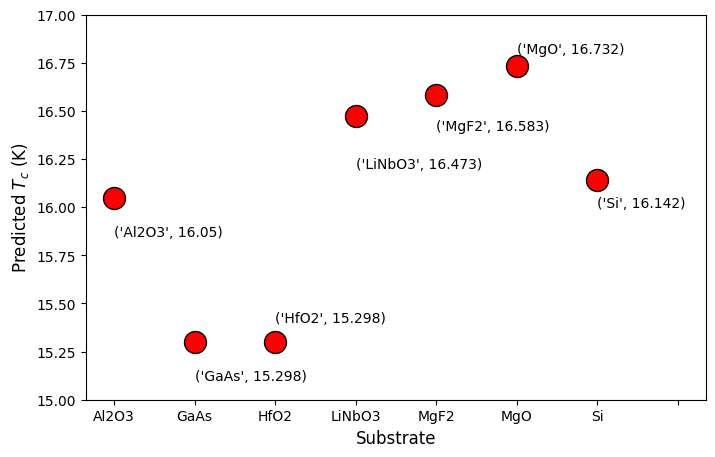

In [25]:
substrate_2 = ['Al2O3', 'GaAs', 'HfO2', 'LiNbO3', 'MgF2', 'MgO', 'Si', '']
predicted_Tc = [16.05, 15.298, 15.298, 16.473, 16.583, 16.732, 16.142,  0]


plt.style.use('default')
plt.figure(figsize=(8,5))
plt.scatter(x=substrate_2, y=predicted_Tc, c='r', edgecolors=(0, 0, 0), marker="o", s=250)

plt.xlabel('Substrate', fontsize=12)
plt.ylabel('Predicted $T_{c}$ (K)', fontsize=12)

plt.text(substrate_2[0], 15.85, (substrate_2[0], 16.050))
plt.text(substrate_2[1], 15.10, (substrate_2[1], 15.298))
plt.text(substrate_2[2], 15.40, (substrate_2[2], 15.298))
plt.text(substrate_2[3], 16.20, (substrate_2[3], 16.473))
plt.text(substrate_2[4], 16.40, (substrate_2[4], 16.583))
plt.text(substrate_2[5], 16.80, (substrate_2[5], 16.732))
plt.text(substrate_2[6], 16.00, (substrate_2[6], 16.142))
#plt.text(substrate_2[7], 10.05, (substrate_2[7], 10.118))

plt.ylim(15,17.0)
#plt.savefig(pwd + '/figures/cross_validated_predictions.png', dpi=350, bbox_inches="tight")
plt.show()

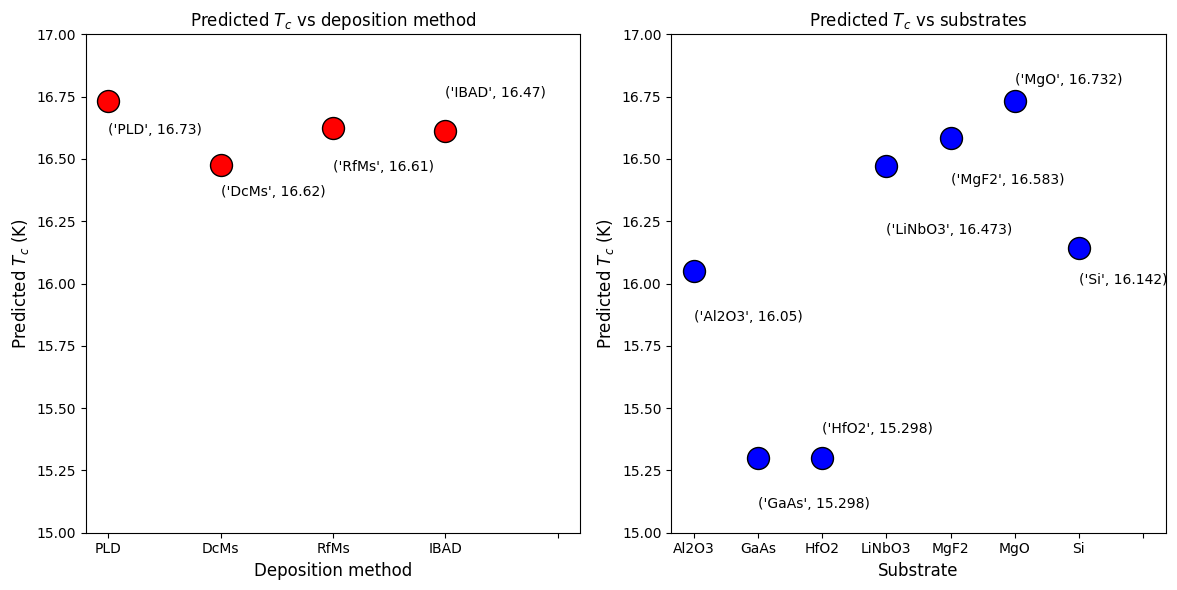

In [26]:
fig, ax = plt.subplots(1, 2, sharex=False, figsize=(12,6))

ax[0].set_title('Predicted $T_{c}$ vs deposition method')
ax[1].set_title('Predicted $T_{c}$ vs substrates')

ax[0].set_ylim(15.0, 17.0)
ax[1].set_ylim(15.0, 17.0)


method_2 = ['PLD','DcMs', 'RfMs', 'IBAD',  '']
predicted_Tc1 = [16.7316, 16.4743, 16.6230, 16.6125,  0]
ax[0].scatter(x=method_2, y=predicted_Tc1, c='r', edgecolors=(0, 0, 0), marker="o", s=250)
ax[0].text(method_2[0], 16.60, (method_2[0], 16.73))
ax[0].text(method_2[1], 16.35, (method_2[1], 16.62))
ax[0].text(method_2[2], 16.45, (method_2[2], 16.61))
ax[0].text(method_2[3], 16.75, (method_2[3], 16.47))


substrate_2 = ['Al2O3', 'GaAs', 'HfO2', 'LiNbO3', 'MgF2', 'MgO', 'Si', '']
predicted_Tc2 = [16.05, 15.298, 15.298, 16.473, 16.583, 16.732, 16.142,  0]
ax[1].scatter(x=substrate_2, y=predicted_Tc2, c='b', edgecolors=(0, 0, 0), marker="o", s=250)
ax[1].text(substrate_2[0], 15.85, (substrate_2[0], 16.050))
ax[1].text(substrate_2[1], 15.10, (substrate_2[1], 15.298))
ax[1].text(substrate_2[2], 15.40, (substrate_2[2], 15.298))
ax[1].text(substrate_2[3], 16.20, (substrate_2[3], 16.473))
ax[1].text(substrate_2[4], 16.40, (substrate_2[4], 16.583))
ax[1].text(substrate_2[5], 16.80, (substrate_2[5], 16.732))
ax[1].text(substrate_2[6], 16.00, (substrate_2[6], 16.142))



ax[0].set_xlabel('Deposition method', fontsize=12)
ax[1].set_xlabel('Substrate', fontsize=12)

ax[0].set_ylabel('Predicted $T_{c}$ (K)', fontsize=12)
ax[1].set_ylabel('Predicted $T_{c}$ (K)', fontsize=12)

plt.tight_layout()
#plt.savefig(pwd+'/Method_Substrate_predicted_Tc.png', dpi=500)
plt.show()